# 01 Define Late Delivery
Compute actual vs estimated delivery days, define delay target, and produce baseline KPI visuals.


In [1]:
from pathlib import Path
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

ROOT = Path('..') if Path.cwd().name == 'notebooks' else Path('.')
if str(ROOT / 'src') not in sys.path:
    sys.path.append(str(ROOT / 'src'))

from utils import derive_delivery_features

sns.set_theme(style='whitegrid')
processed_dir = ROOT / 'data' / 'processed'
fig_dir = ROOT / 'reports' / 'figures'
fig_dir.mkdir(parents=True, exist_ok=True)


In [2]:
parquet_path = processed_dir / 'order_delivery_legs.parquet'
csv_path = processed_dir / 'order_delivery_legs.csv'
if parquet_path.exists():
    legs = pd.read_parquet(parquet_path)
elif csv_path.exists():
    legs = pd.read_csv(csv_path)
else:
    raise FileNotFoundError('Run notebook 00 first.')

feat = derive_delivery_features(legs)
delivered = feat[feat['is_delivered']].copy()

print('Delivered rows:', len(delivered))
print('Late rate (%):', round(delivered['is_late'].mean() * 100, 2))


Delivered rows: 97811
Late rate (%): 8.02


In [3]:
recon = abs(delivered['delay_days'].mean() - (delivered['actual_delivery_days'].mean() - delivered['estimated_delivery_days'].mean()))
print('Reconciliation delta:', recon)
assert recon < 1e-9, 'mean(delay) reconciliation failed'
print('Reconciliation check passed.')


Reconciliation delta: 1.7763568394002505e-15
Reconciliation check passed.


In [4]:
kpi = pd.Series({
    'late_rate_pct': delivered['is_late'].mean() * 100,
    'p50_delay_days': delivered['delay_days'].median(),
    'p90_delay_days': delivered['delay_days'].quantile(0.9),
    'p95_delay_days': delivered['delay_days'].quantile(0.95),
    'mean_estimated_days': delivered['estimated_delivery_days'].mean(),
    'mean_actual_days': delivered['actual_delivery_days'].mean(),
})
print(kpi.round(3).to_string())

monthly = delivered.assign(month=delivered['order_purchase_timestamp'].dt.to_period('M').astype(str)).groupby('month', as_index=False).agg(
    volume=('order_id', 'count'),
    late_rate=('is_late', 'mean'),
    p90_delay=('delay_days', lambda s: s.quantile(0.9)),
)
print('Monthly percentiles and late rate:')
print(monthly.tail(12).round(3).to_string(index=False))


late_rate_pct           8.020
p50_delay_days        -12.022
p90_delay_days         -1.167
p95_delay_days          3.766
mean_estimated_days    23.762
mean_actual_days       12.511
Monthly percentiles and late rate:
  month  volume  late_rate  p90_delay
2017-09    4196      0.051     -3.114
2017-10    4547      0.052     -3.230
2017-11    7385      0.142      2.854
2017-12    5575      0.083     -1.291
2018-01    7182      0.065     -3.224
2018-02    6607      0.159      4.986
2018-03    7096      0.212      7.631
2018-04    6931      0.052     -4.328
2018-05    6863      0.081     -1.057
2018-06    6210      0.013     -7.977
2018-07    6257      0.044     -3.172
2018-08    6470      0.102      0.034


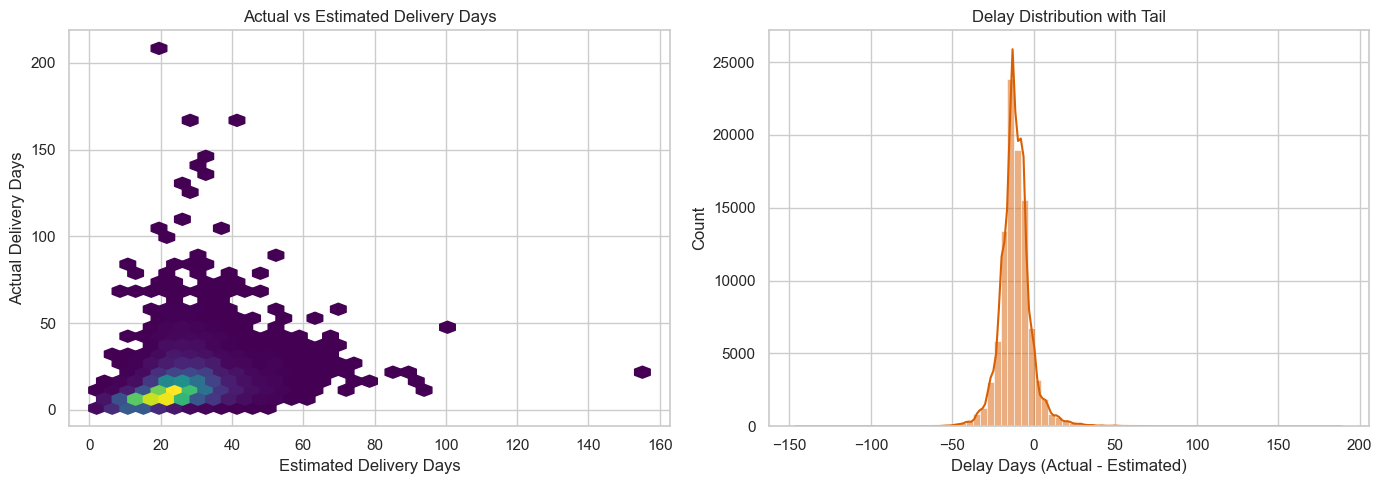

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sample = delivered[['estimated_delivery_days','actual_delivery_days']].dropna().sample(min(20000, len(delivered)), random_state=42)
ax[0].hexbin(sample['estimated_delivery_days'], sample['actual_delivery_days'], gridsize=35, cmap='viridis', mincnt=1)
ax[0].set_xlabel('Estimated Delivery Days')
ax[0].set_ylabel('Actual Delivery Days')
ax[0].set_title('Actual vs Estimated Delivery Days')

sns.histplot(delivered['delay_days'].dropna(), bins=80, kde=True, color='#d95f02', ax=ax[1])
ax[1].set_xlabel('Delay Days (Actual - Estimated)')
ax[1].set_title('Delay Distribution with Tail')

plt.tight_layout()
plt.savefig(fig_dir / '01_baseline_delivery_distributions.png', dpi=150)
plt.show()


Non-delivered orders are excluded from lateness denominator by design (`is_delivered == True`).
